In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit
def CholScalar(A):
    L = np.zeros_like(A, dtype=A.dtype)
    for i in xrange(A.shape[0]):
        for j in xrange(i + 1):
            s = A[j, i]
            for k in xrange(j):
                s = s - L[j, k] * np.conjugate(L[i, k])
            if j < i:
                L[i, j] = np.conjugate(s) / L[j, j]
            else:
                L[i, i] = np.sqrt(np.real(s))
    return L

@jit
def CholDot(A):
    L = np.zeros_like(A, dtype=A.dtype, order="C")
    for i in xrange(A.shape[0]):
        for j in xrange(i + 1):
            if j == 0:
                s = A[j, i]
            else:
                s = A[j, i] - L[j, 0:j].dot(L[i, 0:j].conj())
            if j < i:
                L[i, j] = np.conjugate(s) / L[j, j]
            else:
                L[i, i] = np.sqrt(np.real(s))
    return L

@jit
def CholAxpy(A):
    L = np.zeros_like(A, dtype=A.dtype, order="F")
    n = A.shape[0]
    s = np.zeros(A.shape[0], dtype=A.dtype)
    for i in xrange(A.shape[0]):
        s[i:n] = A[i:n, i]
        for k in xrange(i):
            s[i:n] = s[i:n] - L[i:n, k] * np.conjugate(L[i, k])
        L[i:n, i] = s[i:n] / np.sqrt(np.real(s[i]))
    return L

@jit
def CholMatvec(A):
    L = np.zeros_like(A, dtype=A.dtype, order="F")
    n = A.shape[0]
    s = np.zeros(n, dtype=A.dtype)
    for i in xrange(A.shape[0]):
        if i == 0:
            s[i:n] = A[:, i]
        else:
            s[i:n] = A[i:n, i] - L[i:n, 0:i].dot(L[i, 0:i].conj().T)
        L[i:n, i] = s[i:n] / np.sqrt(np.real(s[i]))
    return L

In [3]:
n = 256
A = np.zeros((n, n), dtype=np.complex128)
A.real = np.random.randn(n, n)
A.imag = np.random.randn(n, n)
# A = np.random.randn(n, n)
A = A.conj().T.dot(A)
L = CholScalar(A)
print np.linalg.norm(A - L.dot(L.conj().T))
L = CholDot(A)
print np.linalg.norm(A - L.dot(L.conj().T))
L = CholAxpy(A)
print np.linalg.norm(A - L.dot(L.conj().T))
L = CholMatvec(A)
print np.linalg.norm(A - L.dot(L.conj().T))

4.91680103676e-12
2.62641580558e-12
5.14767093297e-12
3.16706104966e-12


In [4]:
dims = np.arange(10, 101, 10)
time_scalar = np.zeros(dims.shape[0])
time_dot = np.zeros(dims.shape[0])
time_axpy = np.zeros(dims.shape[0])
time_matvec = np.zeros(dims.shape[0])
time_np = np.zeros(dims.shape[0])
for i, d in enumerate(dims):
    A = np.zeros((d, d), dtype=np.complex128)
    A.real = np.random.randn(d, d)
    A.imag = np.random.randn(d, d)
    A = A.conj().T.dot(A)
    current_time_scalar = %timeit -q -r 3 -o CholScalar(A)
#     time_scalar[i] = np.mean(current_time_scalar.all_runs)
    time_scalar[i] = current_time_scalar.best
    current_time_dot = %timeit -q -r 3 -o CholDot(A)
#     time_dot[i] = np.mean(current_time_dot.all_runs)
    time_dot[i] = current_time_dot.best
    current_time_axpy = %timeit -q -r 3 -o CholAxpy(A)
#     time_axpy[i] = np.mean(current_time_axpy.all_runs)
    time_axpy[i] = current_time_axpy.best
    current_time_matvec = %timeit -q -r 3 -o CholMatvec(A)
#     time_matvec[i] = np.mean(current_time_matvec.all_runs)
    time_matvec[i] = current_time_matvec.best
    current_time_np = %timeit -q -r 3 -o np.linalg.cholesky(A)
#     time_np[i] = np.mean(current_time_np.all_runs)
    time_np[i] = current_time_np.best

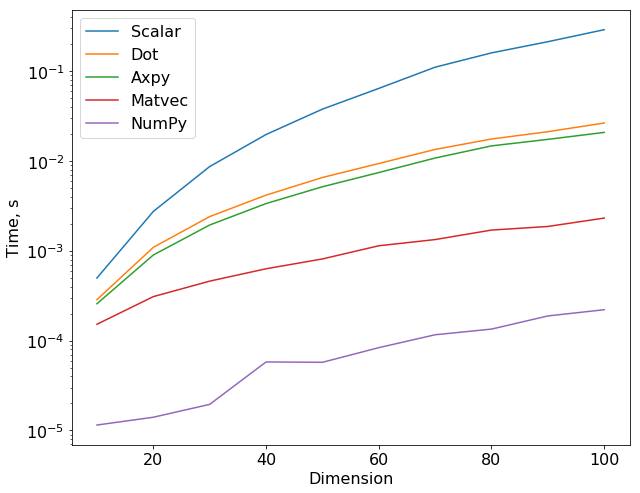

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(dims, time_scalar, label="Scalar")
plt.plot(dims, time_dot, label="Dot")
plt.plot(dims, time_axpy, label="Axpy")
plt.plot(dims, time_matvec, label="Matvec")
plt.plot(dims, time_np, label="NumPy")
plt.yscale("log")
plt.legend(loc="best", fontsize=16)
plt.xlabel("Dimension", fontsize=16)
plt.ylabel("Time, s", fontsize=16)
plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)